COMP5329 – Deep Learning
Assignment 1
Team: 
-	vyun8699 - 530454874
-	gzha9095 – 500543568

Note on imports:
- You are NOT allowed to use Deep Learning frameworks (e.g. PyTorch, Tensorflow, Caffe, and KERAS), or any kinds of auto-grad tools (e.g. autograd).
- Scientific computing packages, such as NumPy and SciPy, are acceptable. 

Note on code sources:
- Week 3: activation function, hidden layers, MLP
- Week 4: momentum, AdaGrad, Adam, SGD
- Week 5: dropout, batch normalization

Code penalties:
- well organized, commented, documented [5]
- Badly written code [-20]
- Not including instructions on how to run code (ie. readme.txt) [-30]

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import time # to track model speeds

In [2]:
# Data loading
train_data = np.load('Assignment1-Dataset/train_data.npy')
train_label = np.load('Assignment1-Dataset/train_label.npy')
test_data = np.load('Assignment1-Dataset/test_data.npy')
test_label = np.load('Assignment1-Dataset/test_label.npy')

#min max
train_min = np.min(train_data)
train_max = np.max(train_data)

adj_train_data = (train_data - train_min) / (train_max - train_min)
adj_test_data = (test_data - train_min) / (train_max - train_min)

#to consider: PCA for dimensionality reduction, which may or may not be beneficial in NN

In [3]:
# data size scaler
# this is intended to help with initial build (e.g. rather than going through 50k of datapoints, we go through factor * 50k)

def create_smaller_dataset(train_data, train_label, n, random_state = None):
    smaller_data = []
    smaller_label = []
    
    unique_labels = np.unique(train_label)

    rs_generator = np.random.RandomState(random_state)
    
    for label in unique_labels:
        label_indices = np.where(train_label == label)[0]
        selected_indices = rs_generator.choice(label_indices, size=int(n*len(label_indices)), replace=False)
        
        smaller_data.extend(train_data[selected_indices])
        smaller_label.extend(train_label[selected_indices])
    
    smaller_data = np.array(smaller_data)
    smaller_label = np.array(smaller_label)

    print('random_state:', random_state)
    print("Shape of input_data:", smaller_data.shape)
    print("Shape of output_data:", smaller_label.shape)
    
    return smaller_data, smaller_label


In [4]:
# all classes are contained here

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
    
    #added in: ReLu

    def __relu(self, x):
        return np.maximum(0,x)

    def __relu_deriv(self, a):
        return np.where(a>0,1,0)
    
    #added in: softmax

    def __softmax(self,x): 
        ''' 
            https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
            https://www.geeksforgeeks.org/how-to-implement-softmax-and-cross-entropy-in-python-and-pytorch/
            
            we subtract np.max in the exps calculation to solve overflow (for large x values) and maintain stability
            reasoning: if we subtract everything by np.max, then largest value is exp(0) = 1
        '''
        exps = np.exp( x -np.max(x, axis =-1, keepdims = True))
        return exps / np.sum(exps, axis =-1, keepdims = True)

    def __softmax_deriv(self,yhat, y_one_hot):
        '''
        https://www.pinecone.io/learn/cross-entropy-loss/
        gradient is the diff between predicted and true values
        '''
        return yhat - y_one_hot 

    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv

class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='softmax',activation='relu', W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        # we randomly assign small values for the weights as the initiallization
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        # if activation == 'logistic':
        #     self.W *= 4

        # we set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)
        
        # we set the size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
    
    # the forward and backward progress (in the hidden layer level) for each training epoch
    # please learn the week2 lec contents carefully to understand these codes. 
    def forward(self, input):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output
    
    #updated to handle softmax at output layer
    def backward(self, delta, output_layer=False):         
        '''
        Note that the output_layer toggle is not used as backward pass calculation is uniform everywhere
        Note backward calculates grad_W and grad_b for the HiddenLayer object, while the iterator is housed in MLP
        '''
        
        self.grad_W = np.dot(np.atleast_2d(self.input).T, np.atleast_2d(delta))
        self.grad_b = np.sum(delta, axis = 0) 
        if self.activation_deriv: 
            delta = np.dot(delta, self.W.T) * self.activation_deriv(self.input)

        return delta
    
class MLP:
    # for initiallization, the code will create all layers automatically based on the provided parameters.     
    def __init__(self, layers, activation=[None,'tanh','softmax']):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[] # this doesnt do anything
        
        self.activation=activation
        for i in range(len(layers) - 1):
            if i == len(layers) - 2:  # Check if it's the last hidden layer
                hidden_layer = HiddenLayer(layers[i], layers[i + 1], activation[i], activation[i + 1], W=np.random.uniform(
                            low=-np.sqrt(6. / (layers[i] + layers[i + 1])),
                            high=np.sqrt(6. / (layers[i] + layers[i + 1])),
                            size=(layers[i], layers[i + 1])).T)
                self.layers.append(hidden_layer)
            else:
                hidden_layer = HiddenLayer(layers[i], layers[i + 1], activation[i], activation[i + 1])
                self.layers.append(hidden_layer)


    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input)
            input=output
        return output

    # define the objection/loss function, we use mean sqaure error (MSE) as the loss
    # you can try other loss, such as cross entropy.
    # when you try to change the loss, you should also consider the backward formula for the new loss as well!
    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        error = y-y_hat
        loss=error**2
        # calculate the MSE's delta of the output layer
        delta=-error*activation_deriv(y_hat)    
        # return loss and delta
        return loss,delta

    #implement cross entropy, mimic input and output of MSE
    def criterion_cross_entropy(self, y, y_hat):
        '''
        shape of y = (1,) <-- a single integer of true class
        shape of y_hat = (10,) <-- values corresponding to each class
        '''
        activation_deriv=Activation(self.activation[-1]).f_deriv
        
        #one hot encode y to match shape of y_hat, value is 0 everywhere, 1 for the positive column
        num_classes = y_hat.shape[0] 
        num_samples = y.shape[0]
        y_one_hot = np.zeros((num_samples,num_classes)) 
        y_one_hot[np.arange(num_samples),y.flatten()] = 1 
        
        # calculate loss, add epsilon to avoid log 0
        loss = np.sum(- y_one_hot * np.log(y_hat + 1e-9)) 
        
        #calculate delta of output layer 
        delta = activation_deriv(y_hat, y_one_hot)

        #return loss and delta
        return loss, delta

    # backward progress  
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]): #self.layers[:-1] returns the list excluding the last element
            delta=layer.backward(delta)

    # update the network weights after backward.
    # make sure you run the backward function before the update function!  
    # note: added assert for debugging  
    def update(self,lr):
        for layer in self.layers:
            assert layer.W.shape == layer.grad_W.shape, 'mismatch in W and grad_W shapes'
            assert layer.b.shape == layer.grad_b.shape, f'mismatch in b {layer.b.shape} and grad_b shapes {layer.grad_b.shape}'
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b

    # define the training function
    # it will return all losses within the whole training process.
    def fit(self,X,y,learning_rate=0.1, epochs=100):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        
        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])
                
                # forward pass
                y_hat = self.forward(X[i])
                #print(y_hat.shape)
                
                # backward pass
                #loss[it],delta=self.criterion_MSE(y[i],y_hat)
                loss[it],delta=self.criterion_cross_entropy(y[i],y_hat)
                
                #backward pass
                self.backward(delta)
                
                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
        return to_return

    # define the prediction function
    # we can use predict function to predict the results of new data, by using the well-trained network.
    def predict(self, x):
        '''adjusted to account for softmax output layer'''
        x = np.array(x)
        output = np.zeros((x.shape[0], 1))  # Prepare output array to store predicted class labels
        for i in np.arange(x.shape[0]):
            probabilities = self.forward(x[i, :])  # Get the softmax probabilities
            predicted_class = np.argmax(probabilities)  # Choose the class with the highest probability
            output[i] = int(predicted_class)  # Assign the predicted class to the output array
        return output

In [15]:
# SINGLE PASS THROUGH EXAMPLE
## I use a single pass through to check speeds as well

# pick data proportion and random state
data_proportion = .3
random_state = 42
input_data, output_data = create_smaller_dataset(adj_train_data, train_label, data_proportion, random_state = random_state)

# fit model
nn = MLP([128,64,64,10], [None,'relu','relu','softmax'])
lr = 0.001
epoch_count = 300

# calculate cross entropy
cross_entropy = nn.fit(input_data, output_data, learning_rate = lr, epochs = epoch_count)
print('loss:%f'%cross_entropy[-1])

# predict output
output = nn.predict(input_data)

random_state: 42
Shape of input_data: (15000, 128)
Shape of output_data: (15000, 1)
loss:1.594642


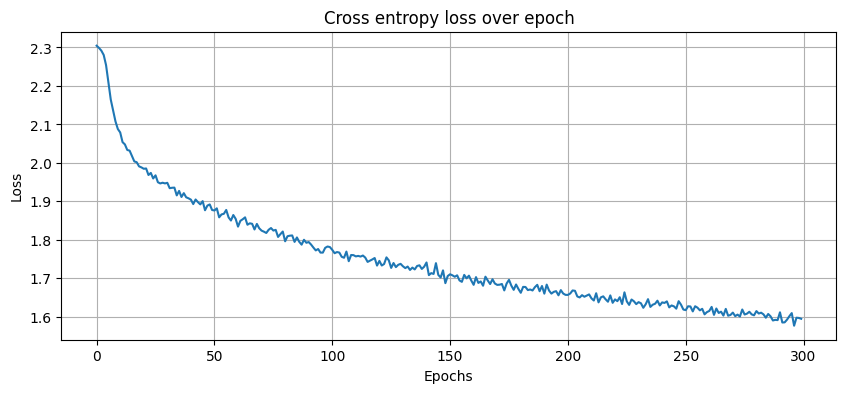

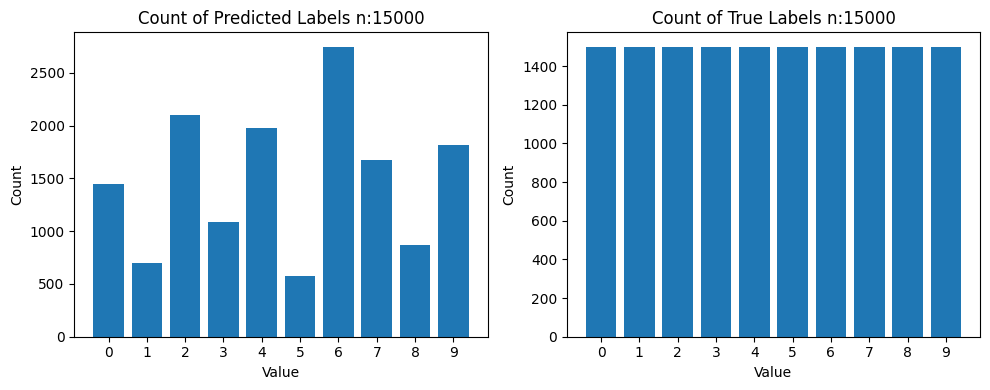

In [16]:
#PLOTS
#plot loss
plt.figure(figsize=(10,4))
plt.title('Cross entropy loss over epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(cross_entropy)
plt.grid()

# plot prediction
output_unique_values, output_counts = np.unique(output, return_counts=True)
true_label_unique_values, true_label_counts = np.unique(output_data, return_counts=True)

# Set up the matplotlib figure and axes, one for each bar chart
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot for 'output'
axs[0].bar(output_unique_values, output_counts)
axs[0].set_xticks(output_unique_values)
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Count')
axs[0].set_title(f'Count of Predicted Labels n:{len(output)}')

# Plot for 'true_label'
axs[1].bar(true_label_unique_values, true_label_counts)
axs[1].set_xticks(true_label_unique_values)
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Count')
axs[1].set_title(f'Count of True Labels n:{len(output_data)}')

plt.tight_layout()  # Adjust the layout to fit both subplots
plt.show()

## UNIT TEST

In [7]:
#hidden layer initialization
def test_hidden_layer_initialization():
    n_in, n_out = 5, 3
    hidden_layer = HiddenLayer(n_in, n_out, 'tanh', 'softmax')
    assert hidden_layer.W.shape == (n_in, n_out), "Incorrect weight shape"
    assert hidden_layer.b.shape == (n_out,), "Incorrect bias shape"
    assert np.all(hidden_layer.W >= -np.sqrt(6. / (n_in + n_out))) and np.all(hidden_layer.W <= np.sqrt(6. / (n_in + n_out))), "Weights initialized outside expected range"

test_hidden_layer_initialization()

nn_simple = MLP([16,4,2], [None, 'relu', 'softmax'])
print(f'Shape of W matrix in 1st layer: {nn_simple.layers[0].W.shape}')
print(f'Shape of grad_W matrix in 1st layer: {nn_simple.layers[0].grad_W.shape}')
print(f'Shape of b in 1st layer: {nn_simple.layers[0].b.shape}')

print(f'Shape of W matrix in 2nd layer: {nn_simple.layers[1].W.shape}')
print(f'Shape of grad_W matrix in 2st layer: {nn_simple.layers[1].grad_W.shape}')
print(f'Shape of b in 2st layer: {nn_simple.layers[1].b.shape}')

# shape looks good

Shape of W matrix in 1st layer: (16, 4)
Shape of grad_W matrix in 1st layer: (16, 4)
Shape of b in 1st layer: (4,)
Shape of W matrix in 2nd layer: (4, 2)
Shape of grad_W matrix in 2st layer: (4, 2)
Shape of b in 2st layer: (2,)


In [8]:
#Forward pass 
def test_forward_pass():
    input_data = np.array([[0.1, 0.2, 0.3, 0.4, 0.5]])
    n_in, n_out = 5, 2
    hidden_layer = HiddenLayer(n_in, n_out)
    output = hidden_layer.forward(input_data)
    assert output.shape == (1, n_out), "Forward pass output shape is incorrect"

test_forward_pass()

#relu forward test
print('relu:')
nn_simple = MLP([5,5], [None, 'relu'])
simple_input = np.arange(0,5,1)
print(f'simple_input: {simple_input}')
simple_pred = nn_simple.forward(simple_input)
print(f'relu_output: {simple_pred}')
print('')

#softmax forward test (to see if sum of probabilities == 1)
print('softmax probability check:')
nn_simple = MLP([10,4], [None, 'softmax'])
simple_input = np.arange(0,10,1)
print(f'simple_input: {simple_input}')
simple_pred = nn_simple.forward(simple_input)
print(f'softmax_output: {simple_pred}')
print(f'sum of softmax output: {sum(simple_pred)}\n')

# sum of probabilities is close to 1 (will never be 1 because I used epsilon to avoid log 0)
# I can't really check the individual calculation of softmax nodes because W and b are randomly initialized
# but by eyeballing, it looks okay (we get a probability distribution)

relu:
simple_input: [0 1 2 3 4]
relu_output: [0.         1.76193399 2.42640712 0.         0.        ]

softmax probability check:
simple_input: [0 1 2 3 4 5 6 7 8 9]
softmax_output: [1.29279408e-05 6.54069287e-09 1.82182498e-08 9.99987047e-01]
sum of softmax output: 0.9999999999999999



In [9]:
#cross entropy 

nn_simple = MLP([5,3], [None, 'softmax'])

y_hat = np.zeros([3,])
y_hat[2] = 1
y = np.array((2,))
loss, delta = nn_simple.criterion_cross_entropy(y,y_hat)

print('loss and delta if class is correct:')
print('- loss:', loss, 'delta', delta)

y_hat = np.zeros([3,])
y_hat[0] = 1
y = np.array((2,))
loss, delta = nn_simple.criterion_cross_entropy(y,y_hat)

print('loss and delta if class is very incorrect:')
print('- loss:', loss, 'delta', delta)

y_hat = np.ones([3,]) / 3
y = np.array((2,))
loss, delta = nn_simple.criterion_cross_entropy(y,y_hat)

print('loss and delta if class is incorrect but probability distb is more balanced:')
print('- loss:', loss, 'delta', delta)

#intuitively the outputs are acceptable

loss and delta if class is correct:
- loss: -1.000000082240371e-09 delta [[0. 0. 0.]]
loss and delta if class is very incorrect:
- loss: 20.72326583694641 delta [[ 1.  0. -1.]]
loss and delta if class is incorrect but probability distb is more balanced:
- loss: 1.0986122856681098 delta [[ 0.33333333  0.33333333 -0.66666667]]


In [12]:
# backward
'''
#stopped working after I changed the structure of softmax in Activation()

def test_backward_pass():
    input_data = np.array([[0.1, 0.2, 0.3, 0.4, 0.5]])
    delta = np.array([[0.01, 0.02]])
    n_in, n_out = 5, 2
    hidden_layer = HiddenLayer(n_in, n_out)
    hidden_layer.forward(input_data)
    delta_back = hidden_layer.backward(delta)
    assert delta_back.shape == input_data.shape, "Backward pass output shape is incorrect"
    assert hidden_layer.grad_W.shape == hidden_layer.W.shape, "Gradient shape for weights is incorrect"
    assert hidden_layer.grad_b.shape == hidden_layer.b.shape, "Gradient shape for biases is incorrect"

test_backward_pass()
'''
# for a [5,3] forward and backward pass, show the resulting delta
nn_simple = MLP([5,3], [None, 'softmax'])
input_data = np.array((1,1,1,1,1))
true_output = np.array((2,))
predicted_output = nn_simple.forward(input_data)
loss, delta = nn_simple.criterion_cross_entropy(true_output,predicted_output)
print('delta:', delta)
print('')

# delta is used to update grad_W
print("grad_W before update:\n", nn_simple.layers[0].grad_W)
nn_simple.backward(delta)
print("grad_W after update:\n", nn_simple.layers[0].grad_W)
print('')

# W is updated by -grad_W 
lr= 1 # << just so the change is obvious
print("Weights before update:\n", nn_simple.layers[0].W)
nn_simple.update(lr)  # Using a learning rate of 0.1
print("Weights after update:\n", nn_simple.layers[0].W)

delta: [[ 0.02262655  0.12129502 -0.14392156]]

grad_W before update:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
grad_W after update:
 [[ 0.02262655  0.12129502 -0.14392156]
 [ 0.02262655  0.12129502 -0.14392156]
 [ 0.02262655  0.12129502 -0.14392156]
 [ 0.02262655  0.12129502 -0.14392156]
 [ 0.02262655  0.12129502 -0.14392156]]

Weights before update:
 [[-0.22819382  0.06806786 -0.25634322]
 [-0.09888555 -0.13736977  0.57845775]
 [-0.47739029 -0.45226427  0.18489408]
 [-0.4683106   0.8515628   0.78432346]
 [-0.57738181 -0.50105682  0.491744  ]]
Weights after update:
 [[-0.25082036 -0.05322716 -0.11242166]
 [-0.12151209 -0.25866479  0.72237931]
 [-0.50001684 -0.57355928  0.32881564]
 [-0.49093715  0.73026778  0.92824503]
 [-0.60000836 -0.62235183  0.63566556]]


### Hyperparameter tuning

In [13]:
def cv_search(input_data, output_data, layer_sizes, activations, learning_rate_list, epoch):
    '''
    layer_sizes = list of list of node counts
    activations = list of list of activations
    learning_rate = float
    '''
    # Initialize and fit the MLP model
    #results = {}
    best_model = None
    lowest_loss = float('inf')

    for (layer_size, activation) in zip(layer_sizes, activations):
        for learning_rate in learning_rate_list:
            
            #start time tracking
            start_time = time.time()
            
            #fit model and calculate loss
            nn = MLP(layer_size, activation)
            cross_entropy = nn.fit(input_data, output_data, learning_rate, epochs=epoch)
            final_loss = cross_entropy[-1]
            
            #end time tracking
            end_time = time.time()
            total_minutes = (end_time - start_time) / 60

            '''
            #save all results
            key = (tuple(layer_size), tuple(activation), learning_rate, epoch)

            results[key] = {
                'final_loss': final_loss,
                'total_minutes': total_minutes,
                'model': nn,
                'cross_entropy': cross_entropy
            }
            '''

            #save best model
            if final_loss < lowest_loss:
                best_model = nn
                cross_entropy = cross_entropy
                lowest_loss = final_loss
                best_parameters = {
                    'layer_size': layer_size,
                    'activation': activation,
                    'learning_rate': learning_rate,
                    'epoch': epoch,
                    'total_minutes': total_minutes
                }
            
            #print progress
            print(f'activation: {activation}, layer: {layer_size},  learning_rate: {learning_rate}, epoch: {epoch}, loss: {final_loss}, total_minutes: {total_minutes:.2f}')

    return best_model, best_parameters, cross_entropy

def plot_best_results(best_parameters, cross_entropy, nn, input_data, output_data):
   print(f'best_parameter: {best_parameters}')
   
   output = nn.predict(input_data)
   
   plt.figure(figsize=(8, 3))
   plt.title('Cross entropy loss over epochs')
   plt.xlabel('Epochs')
   plt.ylabel('Loss')
   plt.plot(cross_entropy)
   #plt.grid()
   plt.show()

   # Plot predictions
   output_unique_values, output_counts = np.unique(output, return_counts=True)
   true_label_unique_values, true_label_counts = np.unique(output_data, return_counts=True)
   
   fig, axs = plt.subplots(1, 2, figsize=(8, 3))
   axs[0].bar(output_unique_values, output_counts)
   axs[0].set_xticks(output_unique_values)
   axs[0].set_xlabel('Value')
   axs[0].set_ylabel('Count')
   axs[0].set_title(f'Count of Predicted Labels n:{len(output)}')
   axs[1].bar(true_label_unique_values, true_label_counts)
   axs[1].set_xticks(true_label_unique_values)
   axs[1].set_xlabel('Value')
   axs[1].set_ylabel('Count')
   axs[1].set_title(f'Count of True Labels n:{len(output_data)}')
   plt.tight_layout()
   plt.show()


In [14]:
# run cv search

#re-create dataset
data_proportion = 1
random_state = 42
input_data, output_data = create_smaller_dataset(adj_train_data, train_label, data_proportion, random_state=random_state)

#cv search input
epoch = 500

layer_sizes = [[128,64,10], 
               [128,64,64,10],
               [128,64,64,64,10]]
activations = [[None,'relu','softmax'],
               [None,'relu','relu','softmax'],
               [None,'relu','relu','relu','softmax']]
learning_rate_list = [0.001] #0.01 is problematic, can't converge in some cases

#implementation
best_model, best_parameters, cross_entropy= cv_search(input_data, output_data,layer_sizes, activations, learning_rate_list, epoch)

# Plot
plot_best_results(best_parameters, cross_entropy, best_model, input_data, output_data)

random_state: 42
Shape of input_data: (50000, 128)
Shape of output_data: (50000, 1)


KeyboardInterrupt: 